# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes â€“ that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocs you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [173]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

The following code block contains an 8x8 matrix that will be used as a maze object:

In [174]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [175]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [176]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


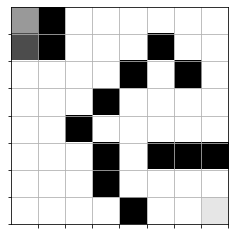

In [177]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [178]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [179]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [180]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [181]:
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    
    # pseudocode:
    # For each epoch:
    #    Agent_cell = randomly select a free cell
    #    Reset the maze with agent set to above position
    #    Hint: Review the reset method in the TreasureMaze.py class.
    #    envstate = Environment.current_state
    #    Hint: Review the observe method in the TreasureMaze.py class.
    #    While state is not game over:
    #        previous_envstate = envstate
    #        Action = randomly choose action (left, right, up, down) either by exploration or by exploitation
    #        envstate, reward, game_status = qmaze.act(action)
    #    Hint: Review the act method in the TreasureMaze.py class.
    #        episode = [previous_envstate, action, reward, envstate, game_status]
    #        Store episode in Experience replay object
    #    Hint: Review the remember method in the GameExperience.py class.
    #        Train neural network model and evaluate loss
    #    Hint: Call GameExperience.get_data to retrieve training data (input and target) and pass to model.fit method 
    #          to train the model. You can call model.evaluate to determine loss.
    #    If the win rate is above the threshold and your model passes the completion check, that would be your epoch.
    for epoch in range(n_epoch):
    # Print start of epoch
        print(f"\nEpoch {epoch+1}/{n_epoch}:")

    # Randomly select starting position for agent
        agent_cell = np.random.randint(0, high=7, size=2)

    # Reset game environment
        qmaze.reset([0,0])
        envstate = qmaze.observe()

    # Initialize variables
        loss = 0
        n_episodes = 0

    # Play game until it's over
    while qmaze.game_status() == 'not_over':
        # Store previous environment state
        previous_envstate = envstate

        # Get valid actions
        valid_actions = qmaze.valid_actions()

        # Choose next action
        if np.random.rand() < epsilon:
            action = random.choice(valid_actions)
        else:
            action = np.argmax(experience.predict(envstate))

        # Take the action and get reward and game status
        envstate, reward, game_status = qmaze.act(action)

        # Increment episode count and store episode in experience replay
        n_episodes += 1
        episode = [previous_envstate, action, reward, envstate, game_status]
        experience.remember(episode)

        # Train model on experience replay
        inputs, targets = experience.get_data()            
        history = model.fit(inputs, targets, epochs=8, batch_size=24, verbose=0)
        loss = model.evaluate(inputs, targets)

        # Check if game is over and update win rate
        if episode[4] == 'win':
            win_history.append(1)
        elif episode[4] == 'lose':
            win_history.append(0)
        win_rate = sum(win_history) / len(win_history) if win_history else 0.0

        # Check win rate and completion check
        if win_rate > epsilon:
            print("Win rate exceeds epsilon threshold")
            if completion_check(model, qmaze):
                print("Completion check passed")
                break
    # Print epoch summary
    print(f"  - Loss: {loss:.4f}")
    print(f"  - Episodes: {n_episodes}")
    print(f"  - Win count: {sum(win_history)}")
    print(f"  - Win rate: {win_rate:.3f}")   

    #Print the epoch, loss, episodes, win count, and win rate for each epoch
    dt = datetime.datetime.now() - start_time
    t = format_time(dt.total_seconds())
    template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
    print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
    # We simply check if training has exhausted all free cells and if in all
    # cases the agent won.
    if win_rate > 0.9 : epsilon = 0.05
    if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
        print("Reached 100%% win rate at epoch: %d" % (epoch,))
    
    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

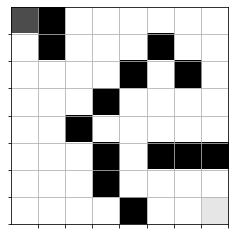

In [182]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [183]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)


Epoch 1/15000:

Epoch 2/15000:

Epoch 3/15000:

Epoch 4/15000:

Epoch 5/15000:

Epoch 6/15000:

Epoch 7/15000:

Epoch 8/15000:

Epoch 9/15000:

Epoch 10/15000:

Epoch 11/15000:

Epoch 12/15000:

Epoch 13/15000:

Epoch 14/15000:

Epoch 15/15000:

Epoch 16/15000:

Epoch 17/15000:

Epoch 18/15000:

Epoch 19/15000:

Epoch 20/15000:

Epoch 21/15000:

Epoch 22/15000:

Epoch 23/15000:

Epoch 24/15000:

Epoch 25/15000:

Epoch 26/15000:

Epoch 27/15000:

Epoch 28/15000:

Epoch 29/15000:

Epoch 30/15000:

Epoch 31/15000:

Epoch 32/15000:

Epoch 33/15000:

Epoch 34/15000:

Epoch 35/15000:

Epoch 36/15000:

Epoch 37/15000:

Epoch 38/15000:

Epoch 39/15000:

Epoch 40/15000:

Epoch 41/15000:

Epoch 42/15000:

Epoch 43/15000:

Epoch 44/15000:

Epoch 45/15000:

Epoch 46/15000:

Epoch 47/15000:

Epoch 48/15000:

Epoch 49/15000:

Epoch 50/15000:

Epoch 51/15000:

Epoch 52/15000:

Epoch 53/15000:

Epoch 54/15000:

Epoch 55/15000:

Epoch 56/15000:

Epoch 57/15000:

Epoch 58/15000:

Epoch 59/15000:

Epoch

Epoch 1048/15000:

Epoch 1049/15000:

Epoch 1050/15000:

Epoch 1051/15000:

Epoch 1052/15000:

Epoch 1053/15000:

Epoch 1054/15000:

Epoch 1055/15000:

Epoch 1056/15000:

Epoch 1057/15000:

Epoch 1058/15000:

Epoch 1059/15000:

Epoch 1060/15000:

Epoch 1061/15000:

Epoch 1062/15000:

Epoch 1063/15000:

Epoch 1064/15000:

Epoch 1065/15000:

Epoch 1066/15000:

Epoch 1067/15000:

Epoch 1068/15000:

Epoch 1069/15000:

Epoch 1070/15000:

Epoch 1071/15000:

Epoch 1072/15000:

Epoch 1073/15000:

Epoch 1074/15000:

Epoch 1075/15000:

Epoch 1076/15000:

Epoch 1077/15000:

Epoch 1078/15000:

Epoch 1079/15000:

Epoch 1080/15000:

Epoch 1081/15000:

Epoch 1082/15000:

Epoch 1083/15000:

Epoch 1084/15000:

Epoch 1085/15000:

Epoch 1086/15000:

Epoch 1087/15000:

Epoch 1088/15000:

Epoch 1089/15000:

Epoch 1090/15000:

Epoch 1091/15000:

Epoch 1092/15000:

Epoch 1093/15000:

Epoch 1094/15000:

Epoch 1095/15000:

Epoch 1096/15000:

Epoch 1097/15000:

Epoch 1098/15000:

Epoch 1099/15000:

Epoch 1100/1


Epoch 2135/15000:

Epoch 2136/15000:

Epoch 2137/15000:

Epoch 2138/15000:

Epoch 2139/15000:

Epoch 2140/15000:

Epoch 2141/15000:

Epoch 2142/15000:

Epoch 2143/15000:

Epoch 2144/15000:

Epoch 2145/15000:

Epoch 2146/15000:

Epoch 2147/15000:

Epoch 2148/15000:

Epoch 2149/15000:

Epoch 2150/15000:

Epoch 2151/15000:

Epoch 2152/15000:

Epoch 2153/15000:

Epoch 2154/15000:

Epoch 2155/15000:

Epoch 2156/15000:

Epoch 2157/15000:

Epoch 2158/15000:

Epoch 2159/15000:

Epoch 2160/15000:

Epoch 2161/15000:

Epoch 2162/15000:

Epoch 2163/15000:

Epoch 2164/15000:

Epoch 2165/15000:

Epoch 2166/15000:

Epoch 2167/15000:

Epoch 2168/15000:

Epoch 2169/15000:

Epoch 2170/15000:

Epoch 2171/15000:

Epoch 2172/15000:

Epoch 2173/15000:

Epoch 2174/15000:

Epoch 2175/15000:

Epoch 2176/15000:

Epoch 2177/15000:

Epoch 2178/15000:

Epoch 2179/15000:

Epoch 2180/15000:

Epoch 2181/15000:

Epoch 2182/15000:

Epoch 2183/15000:

Epoch 2184/15000:

Epoch 2185/15000:

Epoch 2186/15000:

Epoch 2187/


Epoch 3328/15000:

Epoch 3329/15000:

Epoch 3330/15000:

Epoch 3331/15000:

Epoch 3332/15000:

Epoch 3333/15000:

Epoch 3334/15000:

Epoch 3335/15000:

Epoch 3336/15000:

Epoch 3337/15000:

Epoch 3338/15000:

Epoch 3339/15000:

Epoch 3340/15000:

Epoch 3341/15000:

Epoch 3342/15000:

Epoch 3343/15000:

Epoch 3344/15000:

Epoch 3345/15000:

Epoch 3346/15000:

Epoch 3347/15000:

Epoch 3348/15000:

Epoch 3349/15000:

Epoch 3350/15000:

Epoch 3351/15000:

Epoch 3352/15000:

Epoch 3353/15000:

Epoch 3354/15000:

Epoch 3355/15000:

Epoch 3356/15000:

Epoch 3357/15000:

Epoch 3358/15000:

Epoch 3359/15000:

Epoch 3360/15000:

Epoch 3361/15000:

Epoch 3362/15000:

Epoch 3363/15000:

Epoch 3364/15000:

Epoch 3365/15000:

Epoch 3366/15000:

Epoch 3367/15000:

Epoch 3368/15000:

Epoch 3369/15000:

Epoch 3370/15000:

Epoch 3371/15000:

Epoch 3372/15000:

Epoch 3373/15000:

Epoch 3374/15000:

Epoch 3375/15000:

Epoch 3376/15000:

Epoch 3377/15000:

Epoch 3378/15000:

Epoch 3379/15000:

Epoch 3380/

Epoch 4465/15000:

Epoch 4466/15000:

Epoch 4467/15000:

Epoch 4468/15000:

Epoch 4469/15000:

Epoch 4470/15000:

Epoch 4471/15000:

Epoch 4472/15000:

Epoch 4473/15000:

Epoch 4474/15000:

Epoch 4475/15000:

Epoch 4476/15000:

Epoch 4477/15000:

Epoch 4478/15000:

Epoch 4479/15000:

Epoch 4480/15000:

Epoch 4481/15000:

Epoch 4482/15000:

Epoch 4483/15000:

Epoch 4484/15000:

Epoch 4485/15000:

Epoch 4486/15000:

Epoch 4487/15000:

Epoch 4488/15000:

Epoch 4489/15000:

Epoch 4490/15000:

Epoch 4491/15000:

Epoch 4492/15000:

Epoch 4493/15000:

Epoch 4494/15000:

Epoch 4495/15000:

Epoch 4496/15000:

Epoch 4497/15000:

Epoch 4498/15000:

Epoch 4499/15000:

Epoch 4500/15000:

Epoch 4501/15000:

Epoch 4502/15000:

Epoch 4503/15000:

Epoch 4504/15000:

Epoch 4505/15000:

Epoch 4506/15000:

Epoch 4507/15000:

Epoch 4508/15000:

Epoch 4509/15000:

Epoch 4510/15000:

Epoch 4511/15000:

Epoch 4512/15000:

Epoch 4513/15000:

Epoch 4514/15000:

Epoch 4515/15000:

Epoch 4516/15000:

Epoch 4517/1

Epoch 5588/15000:

Epoch 5589/15000:

Epoch 5590/15000:

Epoch 5591/15000:

Epoch 5592/15000:

Epoch 5593/15000:

Epoch 5594/15000:

Epoch 5595/15000:

Epoch 5596/15000:

Epoch 5597/15000:

Epoch 5598/15000:

Epoch 5599/15000:

Epoch 5600/15000:

Epoch 5601/15000:

Epoch 5602/15000:

Epoch 5603/15000:

Epoch 5604/15000:

Epoch 5605/15000:

Epoch 5606/15000:

Epoch 5607/15000:

Epoch 5608/15000:

Epoch 5609/15000:

Epoch 5610/15000:

Epoch 5611/15000:

Epoch 5612/15000:

Epoch 5613/15000:

Epoch 5614/15000:

Epoch 5615/15000:

Epoch 5616/15000:

Epoch 5617/15000:

Epoch 5618/15000:

Epoch 5619/15000:

Epoch 5620/15000:

Epoch 5621/15000:

Epoch 5622/15000:

Epoch 5623/15000:

Epoch 5624/15000:

Epoch 5625/15000:

Epoch 5626/15000:

Epoch 5627/15000:

Epoch 5628/15000:

Epoch 5629/15000:

Epoch 5630/15000:

Epoch 5631/15000:

Epoch 5632/15000:

Epoch 5633/15000:

Epoch 5634/15000:

Epoch 5635/15000:

Epoch 5636/15000:

Epoch 5637/15000:

Epoch 5638/15000:

Epoch 5639/15000:

Epoch 5640/1

Epoch 6673/15000:

Epoch 6674/15000:

Epoch 6675/15000:

Epoch 6676/15000:

Epoch 6677/15000:

Epoch 6678/15000:

Epoch 6679/15000:

Epoch 6680/15000:

Epoch 6681/15000:

Epoch 6682/15000:

Epoch 6683/15000:

Epoch 6684/15000:

Epoch 6685/15000:

Epoch 6686/15000:

Epoch 6687/15000:

Epoch 6688/15000:

Epoch 6689/15000:

Epoch 6690/15000:

Epoch 6691/15000:

Epoch 6692/15000:

Epoch 6693/15000:

Epoch 6694/15000:

Epoch 6695/15000:

Epoch 6696/15000:

Epoch 6697/15000:

Epoch 6698/15000:

Epoch 6699/15000:

Epoch 6700/15000:

Epoch 6701/15000:

Epoch 6702/15000:

Epoch 6703/15000:

Epoch 6704/15000:

Epoch 6705/15000:

Epoch 6706/15000:

Epoch 6707/15000:

Epoch 6708/15000:

Epoch 6709/15000:

Epoch 6710/15000:

Epoch 6711/15000:

Epoch 6712/15000:

Epoch 6713/15000:

Epoch 6714/15000:

Epoch 6715/15000:

Epoch 6716/15000:

Epoch 6717/15000:

Epoch 6718/15000:

Epoch 6719/15000:

Epoch 6720/15000:

Epoch 6721/15000:

Epoch 6722/15000:

Epoch 6723/15000:

Epoch 6724/15000:

Epoch 6725/1

Epoch 7797/15000:

Epoch 7798/15000:

Epoch 7799/15000:

Epoch 7800/15000:

Epoch 7801/15000:

Epoch 7802/15000:

Epoch 7803/15000:

Epoch 7804/15000:

Epoch 7805/15000:

Epoch 7806/15000:

Epoch 7807/15000:

Epoch 7808/15000:

Epoch 7809/15000:

Epoch 7810/15000:

Epoch 7811/15000:

Epoch 7812/15000:

Epoch 7813/15000:

Epoch 7814/15000:

Epoch 7815/15000:

Epoch 7816/15000:

Epoch 7817/15000:

Epoch 7818/15000:

Epoch 7819/15000:

Epoch 7820/15000:

Epoch 7821/15000:

Epoch 7822/15000:

Epoch 7823/15000:

Epoch 7824/15000:

Epoch 7825/15000:

Epoch 7826/15000:

Epoch 7827/15000:

Epoch 7828/15000:

Epoch 7829/15000:

Epoch 7830/15000:

Epoch 7831/15000:

Epoch 7832/15000:

Epoch 7833/15000:

Epoch 7834/15000:

Epoch 7835/15000:

Epoch 7836/15000:

Epoch 7837/15000:

Epoch 7838/15000:

Epoch 7839/15000:

Epoch 7840/15000:

Epoch 7841/15000:

Epoch 7842/15000:

Epoch 7843/15000:

Epoch 7844/15000:

Epoch 7845/15000:

Epoch 7846/15000:

Epoch 7847/15000:

Epoch 7848/15000:

Epoch 7849/1


Epoch 8933/15000:

Epoch 8934/15000:

Epoch 8935/15000:

Epoch 8936/15000:

Epoch 8937/15000:

Epoch 8938/15000:

Epoch 8939/15000:

Epoch 8940/15000:

Epoch 8941/15000:

Epoch 8942/15000:

Epoch 8943/15000:

Epoch 8944/15000:

Epoch 8945/15000:

Epoch 8946/15000:

Epoch 8947/15000:

Epoch 8948/15000:

Epoch 8949/15000:

Epoch 8950/15000:

Epoch 8951/15000:

Epoch 8952/15000:

Epoch 8953/15000:

Epoch 8954/15000:

Epoch 8955/15000:

Epoch 8956/15000:

Epoch 8957/15000:

Epoch 8958/15000:

Epoch 8959/15000:

Epoch 8960/15000:

Epoch 8961/15000:

Epoch 8962/15000:

Epoch 8963/15000:

Epoch 8964/15000:

Epoch 8965/15000:

Epoch 8966/15000:

Epoch 8967/15000:

Epoch 8968/15000:

Epoch 8969/15000:

Epoch 8970/15000:

Epoch 8971/15000:

Epoch 8972/15000:

Epoch 8973/15000:

Epoch 8974/15000:

Epoch 8975/15000:

Epoch 8976/15000:

Epoch 8977/15000:

Epoch 8978/15000:

Epoch 8979/15000:

Epoch 8980/15000:

Epoch 8981/15000:

Epoch 8982/15000:

Epoch 8983/15000:

Epoch 8984/15000:

Epoch 8985/

Epoch 10049/15000:

Epoch 10050/15000:

Epoch 10051/15000:

Epoch 10052/15000:

Epoch 10053/15000:

Epoch 10054/15000:

Epoch 10055/15000:

Epoch 10056/15000:

Epoch 10057/15000:

Epoch 10058/15000:

Epoch 10059/15000:

Epoch 10060/15000:

Epoch 10061/15000:

Epoch 10062/15000:

Epoch 10063/15000:

Epoch 10064/15000:

Epoch 10065/15000:

Epoch 10066/15000:

Epoch 10067/15000:

Epoch 10068/15000:

Epoch 10069/15000:

Epoch 10070/15000:

Epoch 10071/15000:

Epoch 10072/15000:

Epoch 10073/15000:

Epoch 10074/15000:

Epoch 10075/15000:

Epoch 10076/15000:

Epoch 10077/15000:

Epoch 10078/15000:

Epoch 10079/15000:

Epoch 10080/15000:

Epoch 10081/15000:

Epoch 10082/15000:

Epoch 10083/15000:

Epoch 10084/15000:

Epoch 10085/15000:

Epoch 10086/15000:

Epoch 10087/15000:

Epoch 10088/15000:

Epoch 10089/15000:

Epoch 10090/15000:

Epoch 10091/15000:

Epoch 10092/15000:

Epoch 10093/15000:

Epoch 10094/15000:

Epoch 10095/15000:

Epoch 10096/15000:

Epoch 10097/15000:

Epoch 10098/15000:




Epoch 11134/15000:

Epoch 11135/15000:

Epoch 11136/15000:

Epoch 11137/15000:

Epoch 11138/15000:

Epoch 11139/15000:

Epoch 11140/15000:

Epoch 11141/15000:

Epoch 11142/15000:

Epoch 11143/15000:

Epoch 11144/15000:

Epoch 11145/15000:

Epoch 11146/15000:

Epoch 11147/15000:

Epoch 11148/15000:

Epoch 11149/15000:

Epoch 11150/15000:

Epoch 11151/15000:

Epoch 11152/15000:

Epoch 11153/15000:

Epoch 11154/15000:

Epoch 11155/15000:

Epoch 11156/15000:

Epoch 11157/15000:

Epoch 11158/15000:

Epoch 11159/15000:

Epoch 11160/15000:

Epoch 11161/15000:

Epoch 11162/15000:

Epoch 11163/15000:

Epoch 11164/15000:

Epoch 11165/15000:

Epoch 11166/15000:

Epoch 11167/15000:

Epoch 11168/15000:

Epoch 11169/15000:

Epoch 11170/15000:

Epoch 11171/15000:

Epoch 11172/15000:

Epoch 11173/15000:

Epoch 11174/15000:

Epoch 11175/15000:

Epoch 11176/15000:

Epoch 11177/15000:

Epoch 11178/15000:

Epoch 11179/15000:

Epoch 11180/15000:

Epoch 11181/15000:

Epoch 11182/15000:

Epoch 11183/15000:



Epoch 12155/15000:

Epoch 12156/15000:

Epoch 12157/15000:

Epoch 12158/15000:

Epoch 12159/15000:

Epoch 12160/15000:

Epoch 12161/15000:

Epoch 12162/15000:

Epoch 12163/15000:

Epoch 12164/15000:

Epoch 12165/15000:

Epoch 12166/15000:

Epoch 12167/15000:

Epoch 12168/15000:

Epoch 12169/15000:

Epoch 12170/15000:

Epoch 12171/15000:

Epoch 12172/15000:

Epoch 12173/15000:

Epoch 12174/15000:

Epoch 12175/15000:

Epoch 12176/15000:

Epoch 12177/15000:

Epoch 12178/15000:

Epoch 12179/15000:

Epoch 12180/15000:

Epoch 12181/15000:

Epoch 12182/15000:

Epoch 12183/15000:

Epoch 12184/15000:

Epoch 12185/15000:

Epoch 12186/15000:

Epoch 12187/15000:

Epoch 12188/15000:

Epoch 12189/15000:

Epoch 12190/15000:

Epoch 12191/15000:

Epoch 12192/15000:

Epoch 12193/15000:

Epoch 12194/15000:

Epoch 12195/15000:

Epoch 12196/15000:

Epoch 12197/15000:

Epoch 12198/15000:

Epoch 12199/15000:

Epoch 12200/15000:

Epoch 12201/15000:

Epoch 12202/15000:

Epoch 12203/15000:

Epoch 12204/15000:


Epoch 13276/15000:

Epoch 13277/15000:

Epoch 13278/15000:

Epoch 13279/15000:

Epoch 13280/15000:

Epoch 13281/15000:

Epoch 13282/15000:

Epoch 13283/15000:

Epoch 13284/15000:

Epoch 13285/15000:

Epoch 13286/15000:

Epoch 13287/15000:

Epoch 13288/15000:

Epoch 13289/15000:

Epoch 13290/15000:

Epoch 13291/15000:

Epoch 13292/15000:

Epoch 13293/15000:

Epoch 13294/15000:

Epoch 13295/15000:

Epoch 13296/15000:

Epoch 13297/15000:

Epoch 13298/15000:

Epoch 13299/15000:

Epoch 13300/15000:

Epoch 13301/15000:

Epoch 13302/15000:

Epoch 13303/15000:

Epoch 13304/15000:

Epoch 13305/15000:

Epoch 13306/15000:

Epoch 13307/15000:

Epoch 13308/15000:

Epoch 13309/15000:

Epoch 13310/15000:

Epoch 13311/15000:

Epoch 13312/15000:

Epoch 13313/15000:

Epoch 13314/15000:

Epoch 13315/15000:

Epoch 13316/15000:

Epoch 13317/15000:

Epoch 13318/15000:

Epoch 13319/15000:

Epoch 13320/15000:

Epoch 13321/15000:

Epoch 13322/15000:

Epoch 13323/15000:

Epoch 13324/15000:

Epoch 13325/15000:




Epoch 14405/15000:

Epoch 14406/15000:

Epoch 14407/15000:

Epoch 14408/15000:

Epoch 14409/15000:

Epoch 14410/15000:

Epoch 14411/15000:

Epoch 14412/15000:

Epoch 14413/15000:

Epoch 14414/15000:

Epoch 14415/15000:

Epoch 14416/15000:

Epoch 14417/15000:

Epoch 14418/15000:

Epoch 14419/15000:

Epoch 14420/15000:

Epoch 14421/15000:

Epoch 14422/15000:

Epoch 14423/15000:

Epoch 14424/15000:

Epoch 14425/15000:

Epoch 14426/15000:

Epoch 14427/15000:

Epoch 14428/15000:

Epoch 14429/15000:

Epoch 14430/15000:

Epoch 14431/15000:

Epoch 14432/15000:

Epoch 14433/15000:

Epoch 14434/15000:

Epoch 14435/15000:

Epoch 14436/15000:

Epoch 14437/15000:

Epoch 14438/15000:

Epoch 14439/15000:

Epoch 14440/15000:

Epoch 14441/15000:

Epoch 14442/15000:

Epoch 14443/15000:

Epoch 14444/15000:

Epoch 14445/15000:

Epoch 14446/15000:

Epoch 14447/15000:

Epoch 14448/15000:

Epoch 14449/15000:

Epoch 14450/15000:

Epoch 14451/15000:

Epoch 14452/15000:

Epoch 14453/15000:

Epoch 14454/15000:


10/10 [==============================] - 0s 53us/step
  - Loss: 0.0001
  - Episodes: 138
  - Win count: 0
  - Win rate: 0.000
Epoch: 14999/14999 | Loss: 0.0001 | Episodes: 138 | Win count: 0 | Win rate: 0.000 | time: 8.0 seconds
n_epoch: 14999, max_mem: 512, data: 32, time: 8.0 seconds


7.952409

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

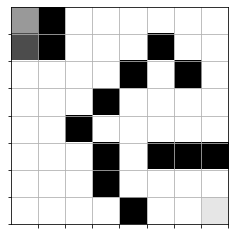

In [184]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

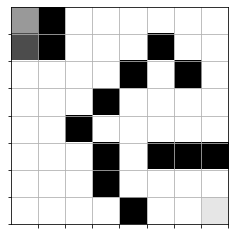

In [185]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.